In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter

plt.style.use("ggplot")
sns.set(font_scale=1.1)

In [163]:
# --- Funciones reutilizables ---

def graficar_linea(df, x, y, titulo, xlabel, ylabel, xticks=None, tendencia=False, grado=1, color='#669bbc'):
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x=x, y=y, color=color)
    if tendencia:
        x_vals = pd.to_numeric(df[x], errors='coerce')  # fuerza numérico
        y_vals = df[y].values
        coef = np.polyfit(x_vals, y_vals, grado)
        poly = np.poly1d(coef)
        plt.plot(x_vals, poly(x_vals), color='red', linestyle='-', linewidth=2, label='Tendencia')
        print(f"Tendencia polinómica grado {grado}: {coef.round(2)}")
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks is not None:
        plt.xticks(ticks=xticks)
    plt.tight_layout()
    plt.show()

def graficar_barras(df, x, y, titulo, xlabel, ylabel, hue=None, palette='viridis', rotacion_xticks=0):
    plt.figure(figsize=(12,6))
    bars = sns.barplot(data=df, x=x, y=y, hue=hue, palette=palette)
    for container in bars.containers:
        bars.bar_label(container, fmt='%.0f', padding=3)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotacion_xticks)
    plt.tight_layout()
    plt.show()

def graficar_heatmap(df, titulo, xlabel, ylabel, cmap='Blues', annot=True, fmt='.2f', vmin=None, vmax=None):
    plt.figure(figsize=(12,6))
    sns.heatmap(df, annot=annot, fmt=fmt, cmap=cmap, linewidths=0.5, linecolor='black', vmin=vmin, vmax=vmax)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def calcular_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

In [164]:
# --- Carga de datos ---
costs = pd.read_csv('../data/costs_us.csv')
orders = pd.read_csv('../data/orders_log_us.csv')
visits = pd.read_csv('../data/visits_log_us.csv')

In [165]:
# Preparar fechas
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])

visits['Duración'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds() / 60  # minutos

visits['Fecha'] = visits['Start Ts'].dt.normalize()
visits['dia'] = visits['Fecha'].dt.day
visits['dia_semana'] = visits['Fecha'].dt.day_name()
visits['semana'] = visits['Fecha'].dt.isocalendar().week
visits['mes'] = visits['Fecha'].dt.month
visits['año'] = visits['Fecha'].dt.year

costs['dt'] = pd.to_datetime(costs['dt'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

## Visitas
¿Cuántas personas lo usan cada día, semana y mes? <br>
¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión). <br>
¿Cuál es la duración de cada sesión? <br>
¿Con qué frecuencia los usuarios regresan? <br>

In [166]:
# Visitas diarias por usuarios únicos
Daily_visits = visits.groupby('Fecha')['Uid'].nunique().reset_index(name='Visitas')
Daily_visits['dia'] = Daily_visits['Fecha'].dt.day
Daily_visits['dia_semana'] = Daily_visits['Fecha'].dt.day_name()
Daily_visits['semana'] = Daily_visits['Fecha'].dt.isocalendar().week
Daily_visits['mes'] = Daily_visits['Fecha'].dt.month
Daily_visits['año'] = Daily_visits['Fecha'].dt.year

In [167]:
# Visitas por día del mes
visits_per_day = Daily_visits.groupby('dia')['Visitas'].sum().reset_index()
mean_visits = visits_per_day['Visitas'].mean()
days_over_mean = visits_per_day[visits_per_day['Visitas'] > mean_visits]['dia']


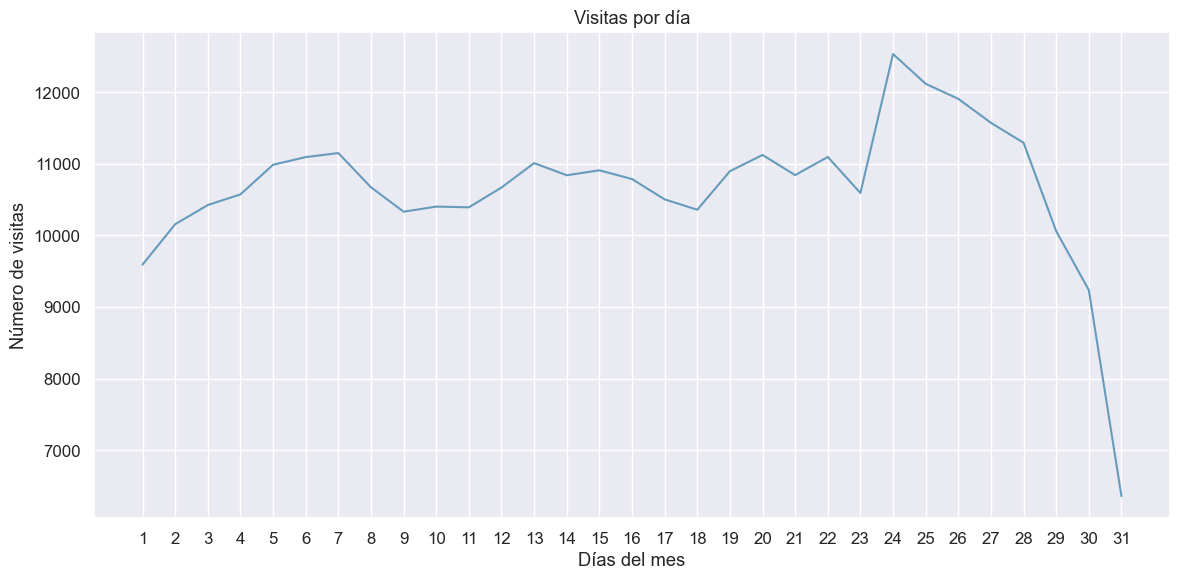

Valor medio de visitas: 10661.58
Días con visitas por encima de la media: [5, 6, 7, 8, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 25, 26, 27, 28]


In [168]:
graficar_linea(
    visits_per_day,
    'dia',
    'Visitas',
    'Visitas por día',
    'Días del mes',
    'Número de visitas',
    xticks=range(1, 32)
)
print(f"Valor medio de visitas: {mean_visits:.2f}")
print(f"Días con visitas por encima de la media: {days_over_mean.tolist()}")


Durante el periodo analizado, el valor medio de visitas fue de 10,661.58. Se identificaron 18 días en los que las visitas superaron este promedio, destacando una mayor actividad entre las semanas 2 y 4 del mes.

In [169]:
# Visitas por día de la semana
visits_per_weekday = Daily_visits.groupby('dia_semana')['Visitas'].sum().reset_index()
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visits_per_weekday['dia_semana'] = pd.Categorical(visits_per_weekday['dia_semana'], categories=orden_dias, ordered=True)
visits_per_weekday = visits_per_weekday.sort_values('dia_semana')


C:\Users\mono_\AppData\Local\Temp\ipykernel_29280\3233582498.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=df, x=x, y=y, hue=hue, palette=palette)


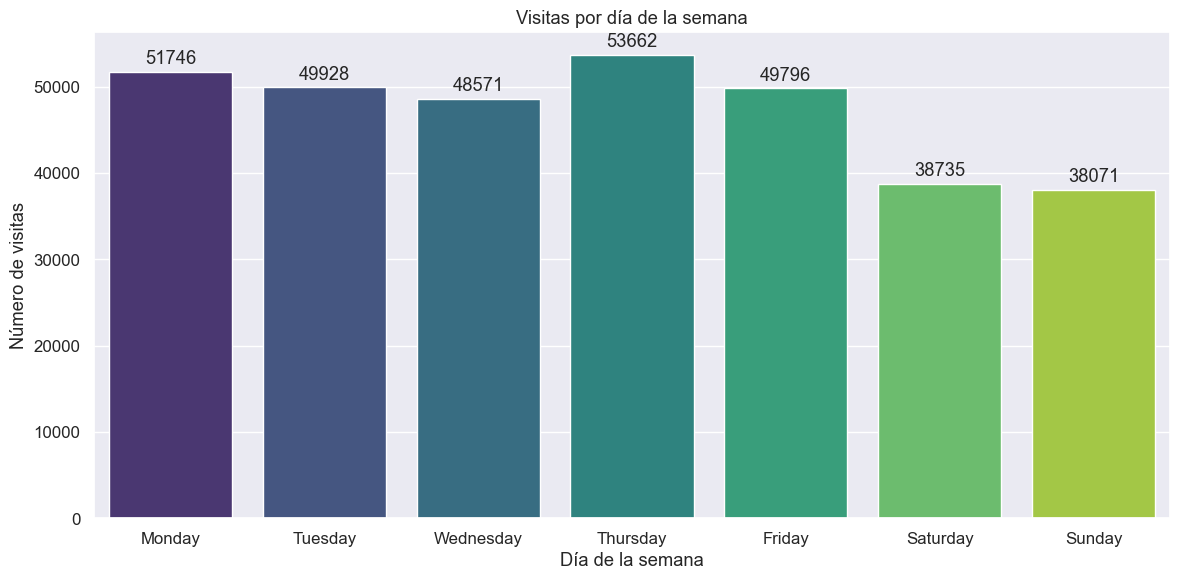

In [170]:
graficar_barras(
    visits_per_weekday,
    'dia_semana',
    'Visitas',
    'Visitas por día de la semana',
    'Día de la semana',
    'Número de visitas'
)

Con esto determinamos que el dia mas fuerte de la semana en visitas es el dia Jueves.<Br>
Adicional se cuenta con un decreso importante de las visitas durante el fin de semana

Tendencia polinómica grado 1: [  12.8  6016.64]


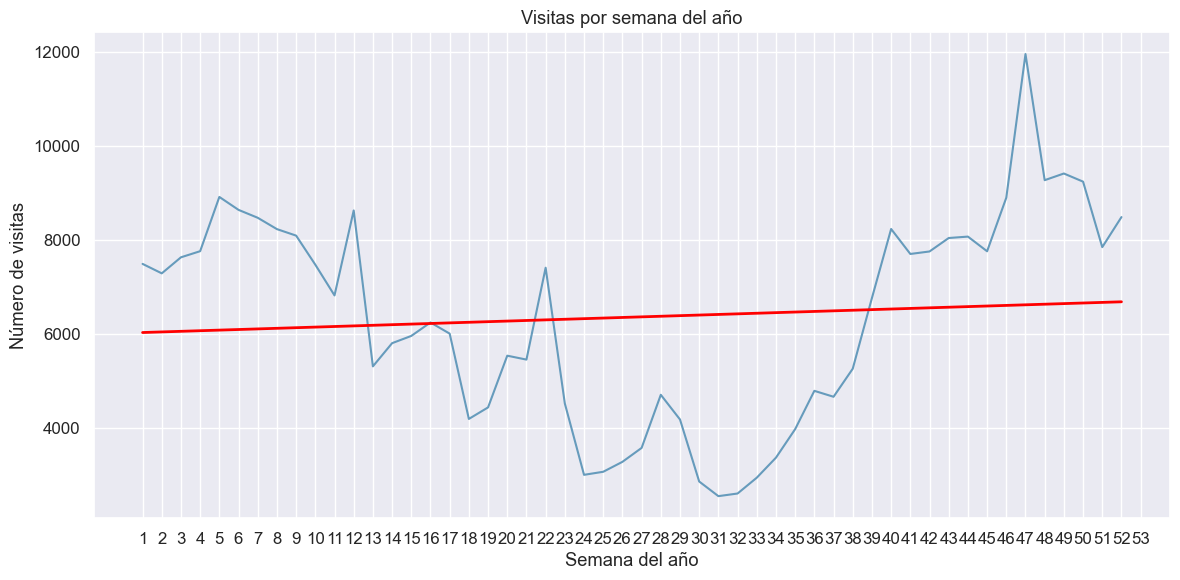

In [171]:
# Visitas por semana del año
visits_per_week = Daily_visits.groupby('semana')['Visitas'].sum().reset_index()
graficar_linea(
    visits_per_week,
    'semana',
    'Visitas',
    'Visitas por semana del año',
    'Semana del año',
    'Número de visitas',
    xticks=range(1, 54),
    tendencia=True,
    grado=1
)

Se observa una ligera tendencia creciente en las visitas a lo largo del tiempo. La pendiente de la línea es 12.8, lo que indica que, en promedio, las visitas aumentan en aproximadamente 13 visitas por semana.

In [172]:
# Visitas por mes y año
visits_per_month = Daily_visits.groupby(['año', 'mes'])['Visitas'].sum().reset_index()
visits_per_month = visits_per_month.sort_values(['año', 'mes'])
meses_abrev = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
visits_per_month['año_mes'] = visits_per_month['año'].astype(str) + '-' + visits_per_month['mes'].astype(str).str.zfill(2)
visits_per_month['label'] = visits_per_month.apply(lambda r: f"{r['año']}-{meses_abrev[r['mes']-1]}", axis=1)

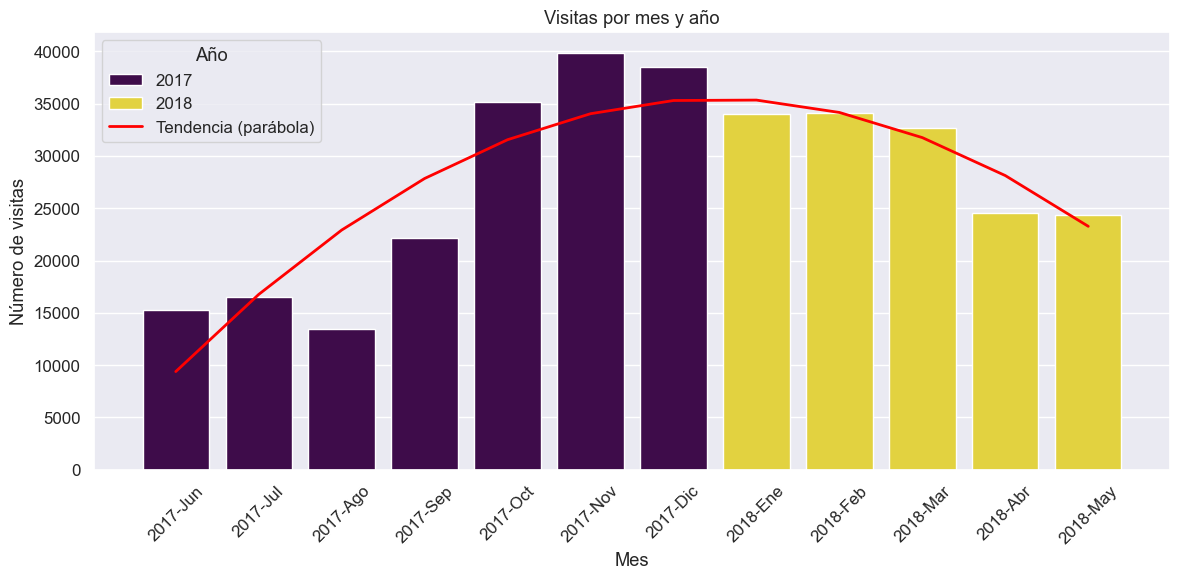

Coeficientes tendencia polinómica grado 2: [-611.41 7988.04 9389.24]


In [173]:
plt.figure(figsize=(12,6))
bars = sns.barplot(data=visits_per_month, x='label', y='Visitas', hue='año', palette='viridis')
x_vals = np.arange(len(visits_per_month))
y_vals = visits_per_month['Visitas'].values
coef = np.polyfit(x_vals, y_vals, 2)
poly = np.poly1d(coef)
plt.plot(x_vals, poly(x_vals), color='red', linewidth=2, label='Tendencia (parábola)')
plt.title('Visitas por mes y año')
plt.xlabel('Mes')
plt.ylabel('Número de visitas')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()
print(f"Coeficientes tendencia polinómica grado 2: {coef.round(2)}")

Como se puede observar en la grafica durante el año los valores van creciendo hasta llegar al inicio del año 2018. Esto podria significar un incremento por temporada.

Para analizar la duración de las visitas, realizamos un histograma. Sin embargo, antes de ello, es fundamental asegurarnos de que los datos no contengan valores atípicos que puedan distorsionar los resultados, ya que el objetivo es observar el comportamiento general de la mayoría de las visitas.

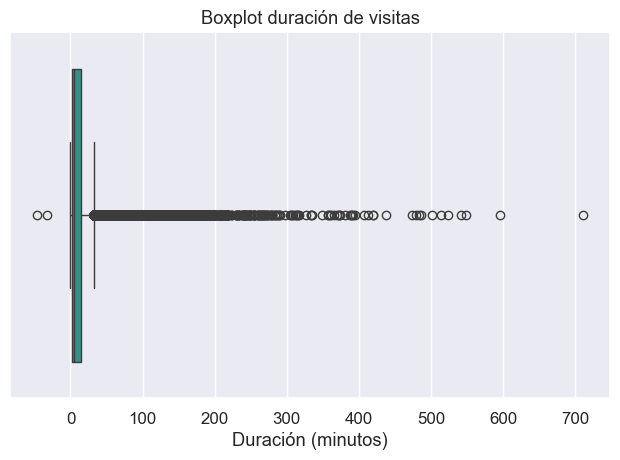

Limite inferior: -16.00 min, Limite superior: 32.00 min
% visitas duración típica: 93.14%


In [174]:
# --- Duración y outliers ---

lim_inf, lim_sup = calcular_iqr(visits, 'Duración')
visits_tipic = visits[(visits['Duración'] >= lim_inf) & (visits['Duración'] <= lim_sup)]

sns.boxplot(data=visits, x='Duración', color='#2a9d8f')
plt.title('Boxplot duración de visitas')
plt.xlabel('Duración (minutos)')
plt.tight_layout()
plt.show()
print(f"Limite inferior: {lim_inf:.2f} min, Limite superior: {lim_sup:.2f} min")
print(f"% visitas duración típica: {100 * len(visits_tipic) / len(visits):.2f}%")

Con este análisis, determinamos que el 93.14% de los datos se mantienen dentro de un rango típico, lo cual permite obtener un análisis más preciso y representativo sobre la duración de las visitas.

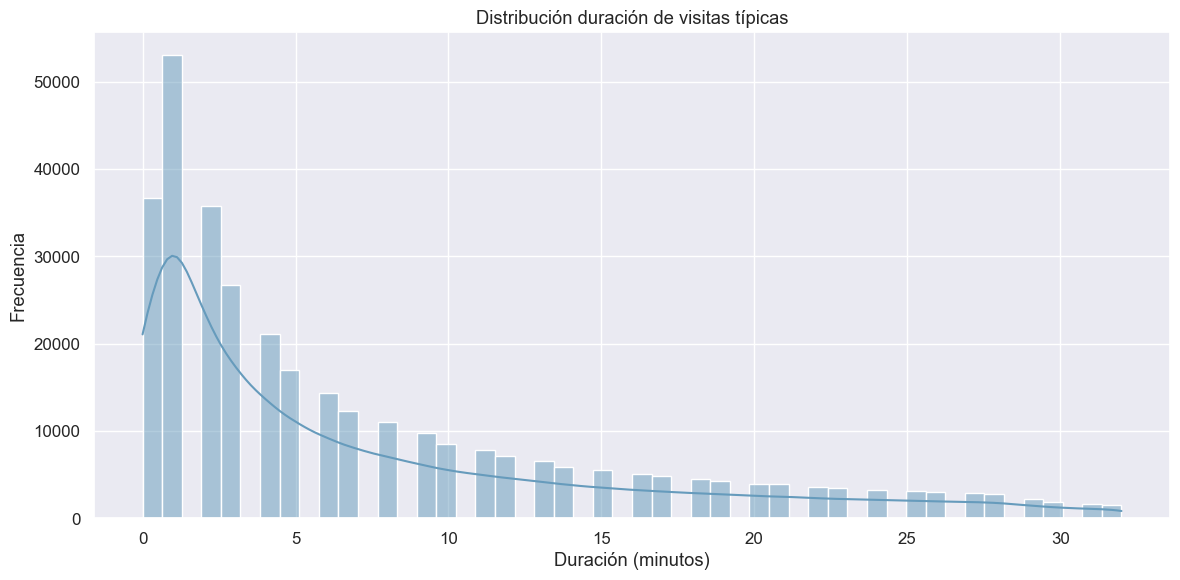

Duración media: 7.42 min
Duración máxima: 32.00 min


In [175]:
plt.figure(figsize=(12,6))
sns.histplot(visits_tipic['Duración'], bins=50, kde=True, color='#669bbc')
plt.title('Distribución duración de visitas típicas')
plt.xlabel('Duración (minutos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

print(f"Duración media: {visits_tipic['Duración'].mean():.2f} min")
print(f"Duración máxima: {visits_tipic['Duración'].max():.2f} min")


Como se observa en el histograma, más de 50,000 usuarios registraron una duración de visita entre 1 y 5 minutos. El promedio general es de 7.42 minutos por visita, mientras que la duración máxima alcanzada fue de 32 minutos.

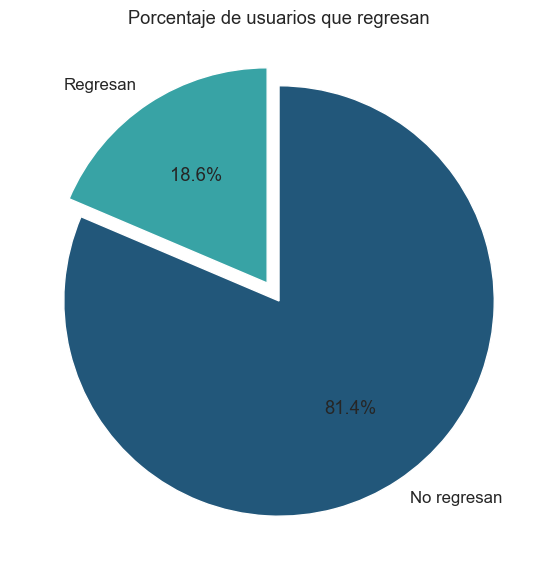

Número usuarios que regresan: 52128
% usuarios que regresan: 18.60%


In [176]:
# --- Usuarios que regresan ---

visits['Regreso'] = visits['Uid'].duplicated(keep='last').astype(int)
regresan = visits[visits['Regreso'] == 1]['Uid'].nunique()
no_regresan = visits[visits['Regreso'] == 0]['Uid'].nunique()
total_users = regresan + no_regresan
porc_regresan = regresan / total_users * 100

plt.figure(figsize=(12,6))
plt.pie([regresan, no_regresan], labels=['Regresan', 'No regresan'], autopct='%1.1f%%',
        colors=['#38a3a5', '#22577a'], startangle=90, explode=(0.1, 0))
plt.title('Porcentaje de usuarios que regresan')
plt.tight_layout()
plt.show()

print(f"Número usuarios que regresan: {regresan}")
print(f"% usuarios que regresan: {porc_regresan:.2f}%")

Se identificaron 52,128 usuarios que regresan al sitio, lo que representa aproximadamente el 18.60% del total de usuarios. Este indicador refleja el nivel de fidelización y compromiso de los visitantes con la plataforma.

De manera similar al análisis previo, antes de construir el histograma del número de visitas de usuarios que regresan, es necesario aislar y eliminar los valores atípicos. Esto garantizará que el estudio refleje con mayor precisión el comportamiento típico de estos usuarios.

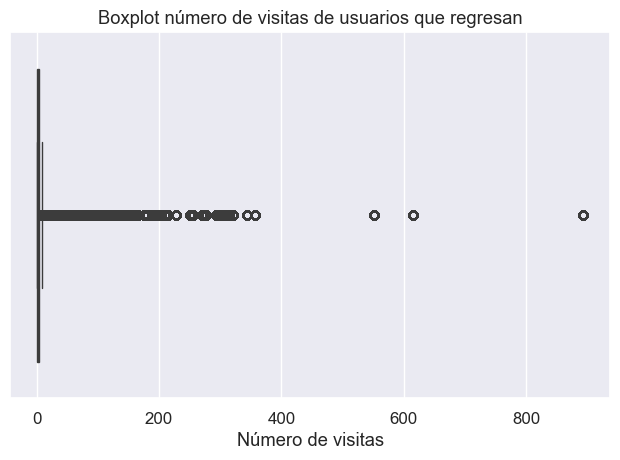

Límite inferior visitas típicas: -13.50
Límite superior visitas típicas: 30.50
% usuarios regresan con visitas típicas: 81.70%


In [177]:
# Boxplot número visitas para usuarios que regresan
visits['Numero de visitas'] = visits.groupby('Uid')['Uid'].transform('count')
Regreso = visits[visits['Regreso'] == 1]

lim_inf_visitas, lim_sup_visitas = calcular_iqr(Regreso, 'Numero de visitas')
Regreso_tipic = Regreso[(Regreso['Numero de visitas'] >= lim_inf_visitas) & (Regreso['Numero de visitas'] <= lim_sup_visitas)]

sns.boxplot(data=visits, x='Numero de visitas', color='#2a9d8f')
plt.title('Boxplot número de visitas de usuarios que regresan')
plt.xlabel('Número de visitas')
plt.tight_layout()
plt.show()

print(f"Límite inferior visitas típicas: {lim_inf_visitas:.2f}")
print(f"Límite superior visitas típicas: {lim_sup_visitas:.2f}")
print(f"% usuarios regresan con visitas típicas: {100 * len(Regreso_tipic)/len(Regreso):.2f}%")

Tras eliminar los valores atípicos, se establecieron límites para considerar visitas típicas entre 0 y 30.5 visitas. Bajo este rango, se determinó que el 81.70% de los usuarios que regresan lo hacen con un comportamiento dentro de lo esperado, lo que valida la consistencia de su actividad en el sitio.

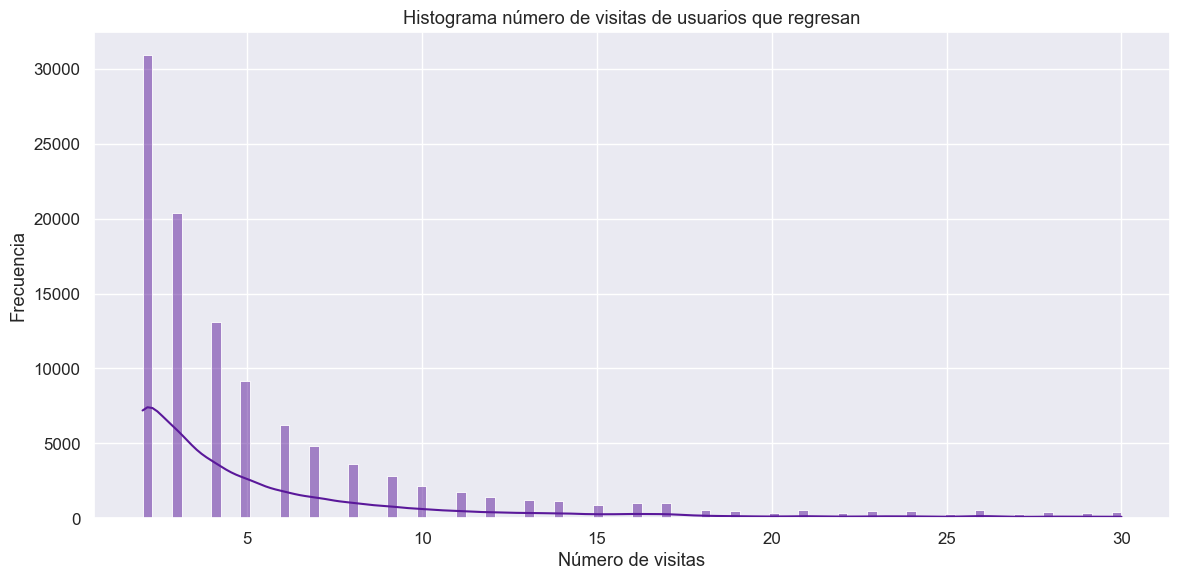

Duración media visitas usuarios que regresan: 5.74 veces
Máximo número de visitas usuarios que regresan: 30 veces


In [178]:
plt.figure(figsize=(12,6))
sns.histplot(Regreso_tipic['Numero de visitas'], bins=100, kde=True, color='#5a189a')
plt.title('Histograma número de visitas de usuarios que regresan')
plt.xlabel('Número de visitas')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

print(f"Duración media visitas usuarios que regresan: {Regreso_tipic['Numero de visitas'].mean():.2f} veces")
print(f"Máximo número de visitas usuarios que regresan: {Regreso_tipic['Numero de visitas'].max()} veces")

Como resultado, se determinó que más de 30,000 usuarios regresan entre 1 y 5 veces, con un promedio general de 5.74 visitas de retorno por usuario. El valor máximo registrado fue de 30 visitas, lo que refleja que, aunque la mayoría regresa pocas veces, existe un grupo reducido de usuarios altamente recurrentes.

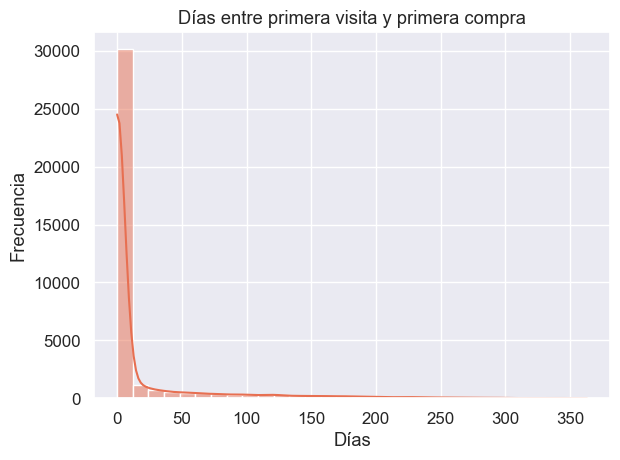

Promedio días entre primera visita y compra: 16.73


In [179]:
# --- Cohortes: diferencia primera visita a primera compra ---

primera_visita = visits.groupby('Uid')['Start Ts'].min().reset_index()
Primera_compra = orders.groupby('Uid')['Buy Ts'].min().reset_index()
Primera_compra.rename(columns={'Buy Ts': 'First_order'}, inplace=True)
usuarios = pd.merge(primera_visita, Primera_compra, on='Uid', how='inner')
usuarios['dias_primera_visita_a_compra'] = (usuarios['First_order'] - usuarios['Start Ts']).dt.days

sns.histplot(usuarios['dias_primera_visita_a_compra'], bins=30, kde=True, color='#e76f51')
plt.title('Días entre primera visita y primera compra')
plt.xlabel('Días')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()
print(f"Promedio días entre primera visita y compra: {usuarios['dias_primera_visita_a_compra'].mean():.2f}")

El análisis muestra que la mayoría de los usuarios concretan su primera compra antes de la visita número 50, siendo el promedio general la visita 17, lo cual sugiere un patrón de conversión temprano en el ciclo de interacción.

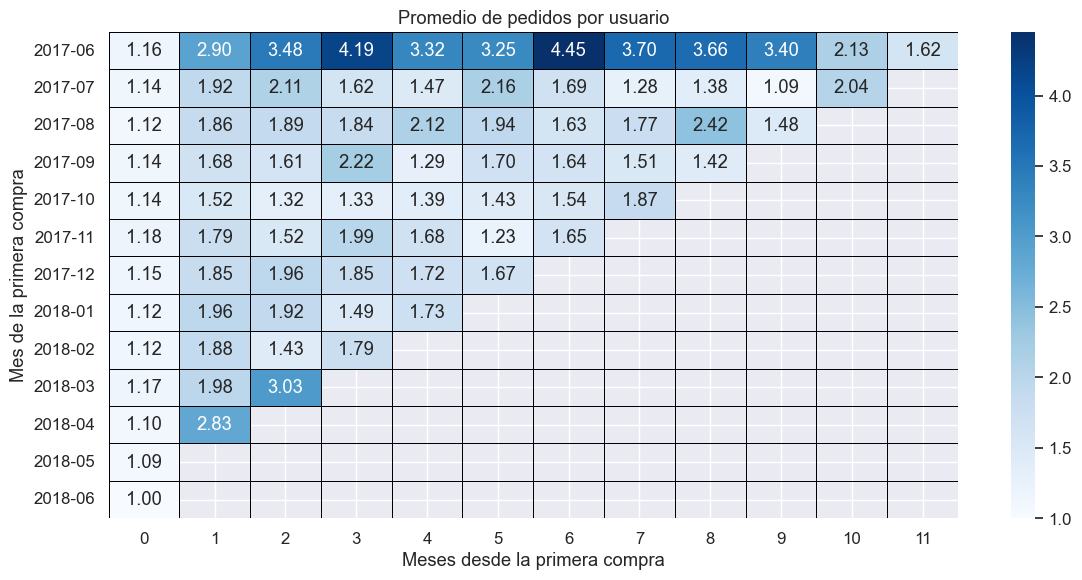

In [180]:
# --- Cohortes agrupadas y cohort_lifetime ---

orders = orders.merge(Primera_compra, on='Uid', how='left')
orders['order_month'] = orders['Buy Ts'].dt.to_period('M')
orders['First_order_month'] = orders['First_order'].dt.to_period('M')

Orders_grouped_by_cohorts = orders.groupby(['First_order_month', 'order_month']).agg({'Uid':'nunique', 'Buy Ts':'count'}).reset_index()
Orders_grouped_by_cohorts['Orders_per_user'] = Orders_grouped_by_cohorts['Buy Ts'] / Orders_grouped_by_cohorts['Uid']
Orders_grouped_by_cohorts['cohort_lifetime'] = (Orders_grouped_by_cohorts['order_month'] - Orders_grouped_by_cohorts['First_order_month']).apply(attrgetter('n')).astype(int)

Lifetime_pivot = Orders_grouped_by_cohorts.pivot(index='First_order_month', columns='cohort_lifetime', values='Orders_per_user')

graficar_heatmap(Lifetime_pivot, 'Promedio de pedidos por usuario', 'Meses desde la primera compra', 'Mes de la primera compra')

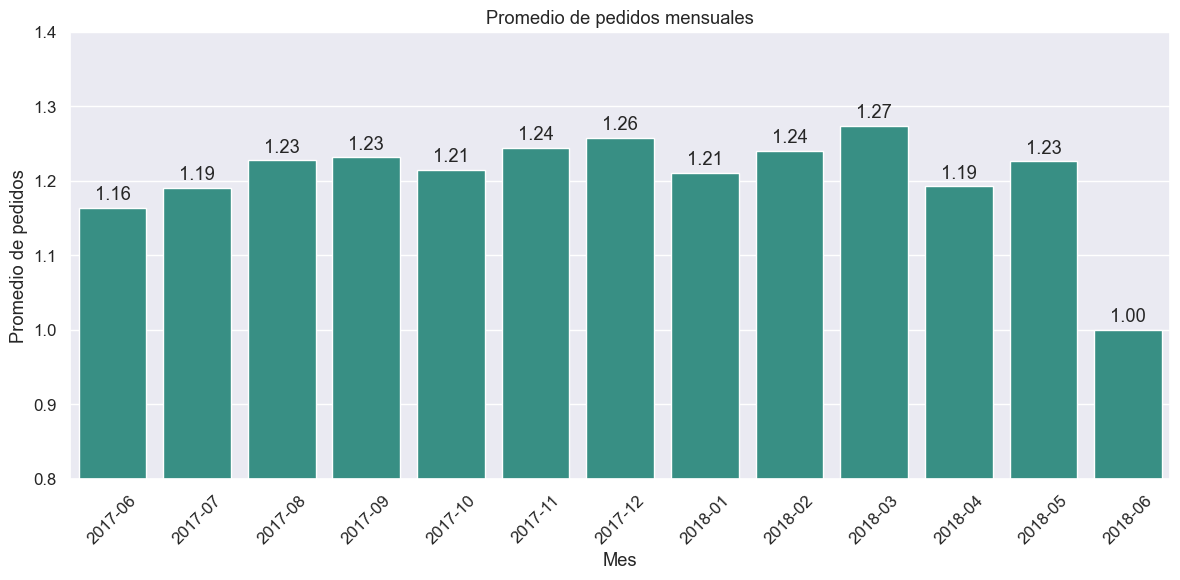

In [181]:
# --- Promedio mensual de pedidos ---

monthly_orders = orders.groupby([orders['Buy Ts'].dt.to_period('M'), 'Uid']).size().reset_index(name='order_count')
mean_orders_monthly = monthly_orders.groupby('Buy Ts')['order_count'].mean().reset_index()
mean_orders_general = monthly_orders.groupby('Uid')['order_count'].mean().reset_index()

plt.figure(figsize=(12,6))
bars = sns.barplot(x=mean_orders_monthly['Buy Ts'].astype(str), y=mean_orders_monthly['order_count'], color='#2a9d8f')
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', padding=3)
plt.title('Promedio de pedidos mensuales')
plt.ylim(0.8, 1.4)
plt.xlabel('Mes')
plt.ylabel('Promedio de pedidos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como se puede obsevar en la grafica. se tiene promedio de compras por usuario mensuales estables.

In [182]:
# 1) LTV (Customer Lifetime Value)
margin_rate = 0.5
# Cohort sizes (número de compradores por mes de primera compra)
cohort_sizes = orders.groupby('First_order_month').agg(n_buyers=('Uid','nunique')).reset_index()

# Ingresos por cohorte y mes de compra
cohorts_rev = (
    orders
    .groupby(['First_order_month', 'order_month'])
    .agg(Revenue=('Revenue','sum'))
    .reset_index()
)

# Merge y cálculo de GP acumulado
report = (
    cohort_sizes
    .merge(cohorts_rev, on='First_order_month', how='left')
    .assign(gp=lambda df: df['Revenue'] * margin_rate)
)
report['gp_cum'] = report.groupby('First_order_month')['gp'].cumsum()

# Meses desde la primera compra (cohort lifetime)
report['months_since_first_purchase'] = (
    (report['order_month'] - report['First_order_month'])
    .apply(attrgetter('n'))
    .astype(int)
)

# LTV por cohorte
report['ltv'] = report['gp_cum'] / report['n_buyers']


In [183]:
# Pivot para heatmap
ltv_pivot = report.pivot_table(
    index='First_order_month',
    columns='months_since_first_purchase',
    values='ltv',
    aggfunc='mean'
).round(2).fillna(0)


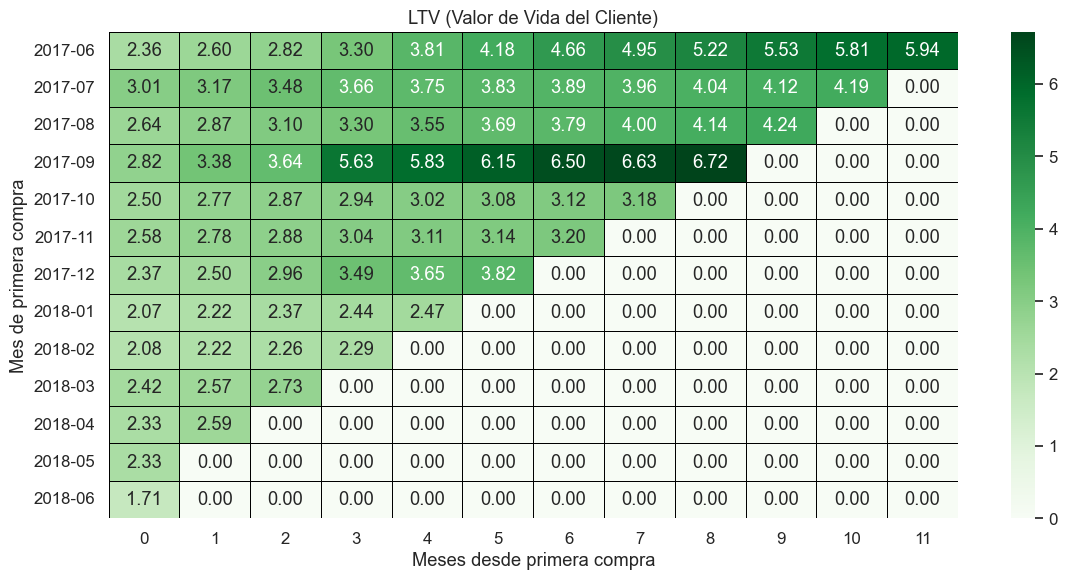

In [184]:
# Visualización LTV
graficar_heatmap(
    ltv_pivot,
    titulo='LTV (Valor de Vida del Cliente)',
    xlabel='Meses desde primera compra',
    ylabel='Mes de primera compra',
    cmap='Greens'
)

Como se observa en la gráfica de calor, los clientes que realizaron su primera compra en septiembre de 2017 y continuaron comprando entre 3 y 8 meses después, muestran un valor de retorno significativamente más alto que el promedio general de cohortes."

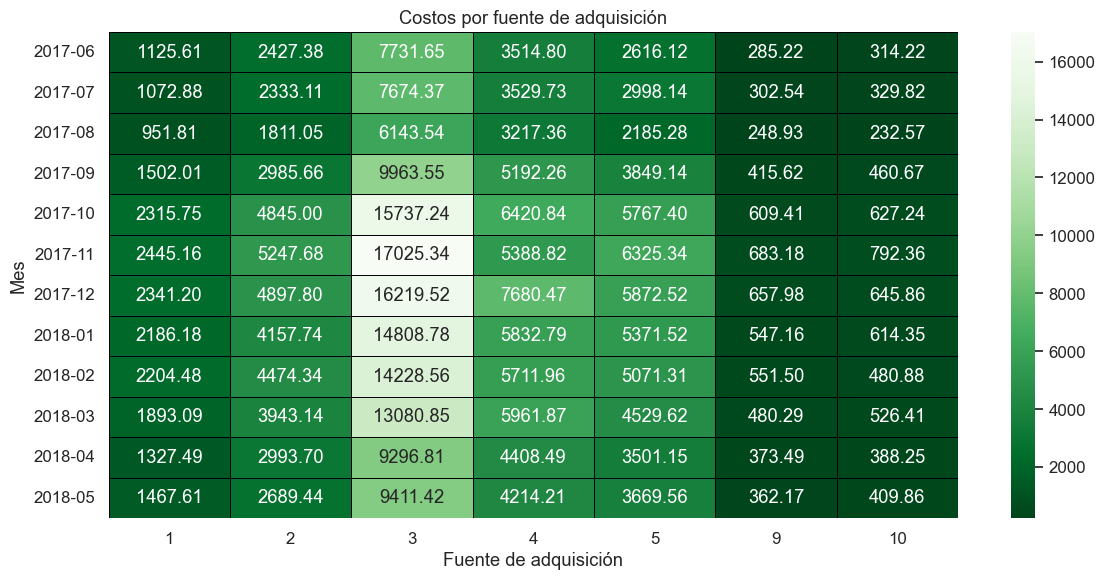

In [185]:
# 2) CAC (Customer Acquisition Cost)
# Costos por mes y fuente
costs['month'] = costs['dt'].dt.to_period('M')
costs_pivot = (
    costs
    .groupby(['month','source_id'])['costs']
    .sum()
    .reset_index()
    .pivot(index='month', columns='source_id', values='costs')
    .fillna(0)
)

# Visualización de costos por fuente
plt.figure(figsize=(12, 6))
sns.heatmap(
    costs_pivot,
    annot=True,
    fmt='.2f',
    cmap='Greens_r',
    linewidths=0.5,
    linecolor='black'
)
plt.title('Costos por fuente de adquisición')
plt.xlabel('Fuente de adquisición')
plt.ylabel('Mes')
plt.tight_layout()
plt.show()



Como se observa en el gráfico de calor, la fuente de adquisición 3 representó un impacto significativo en costos durante el periodo de noviembre de 2017 a marzo de 2018. A lo largo del análisis, esta fuente mantiene los costos más altos en comparación con las demás, mientras que las fuentes 9 y 10 destacan por generar los costos de adquisición más bajos.

C:\Users\mono_\AppData\Local\Temp\ipykernel_29280\1948948801.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sells['order_count'].replace(0, np.nan, inplace=True)


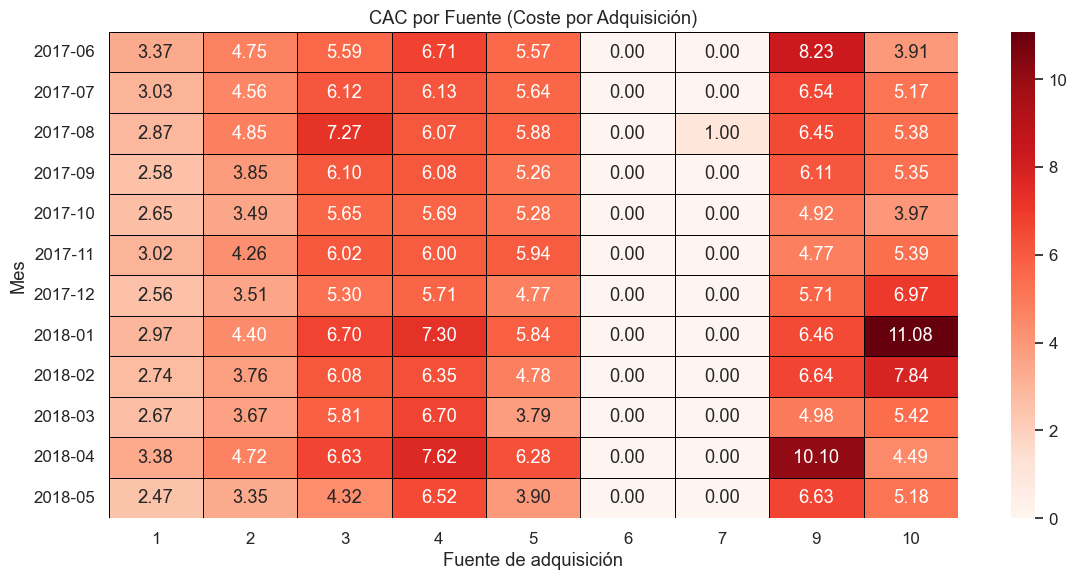

In [186]:
# Ventas (visitas → pedidos) por mes y fuente
visits_monthly = (
    visits
    .groupby([visits['Start Ts'].dt.to_period('M'), 'Uid', 'Source Id'])
    .size()
    .reset_index(name='visits_count')
)
orders_monthly = (
    orders
    .groupby([orders['Buy Ts'].dt.to_period('M'), 'Uid'])
    .size()
    .reset_index(name='order_count')
)
sells = (
    visits_monthly
    .merge(orders_monthly, left_on=['Start Ts','Uid'], right_on=['Buy Ts','Uid'], how='left')
    .groupby(['Start Ts','Source Id'])
    .agg(visits_count=('visits_count','sum'), order_count=('order_count','sum'))
    .reset_index()
    .rename(columns={'Start Ts':'month','Source Id':'source_id'})
)
sells['order_count'].replace(0, np.nan, inplace=True)
sells['CAC'] = sells['visits_count'] / sells['order_count']
cac_pivot = (
    sells
    .pivot(index='month', columns='source_id', values='CAC')
    .fillna(0)
)

# Visualización CAC
graficar_heatmap(
    cac_pivot,
    titulo='CAC por Fuente (Coste por Adquisición)',
    xlabel='Fuente de adquisición',
    ylabel='Mes',
    cmap='Reds',
    vmin=0,
    vmax=cac_pivot.max().max()
)

Como se observa en el gráfico de calor, las fuentes 9 (abril 2018) y 10 (enero 2018) presentaron costos de adquisición superiores al resto durante esos períodos. Además, las fuentes 3 y 4 muestran consistentemente altos costos de adquisición a lo largo del tiempo.

   order_month Source Id  Revenue    costs      ROMI
5      2017-06         9   752.06   285.22  1.636772
0      2017-06         1  2563.84  1125.61  1.277734
6      2017-06        10   432.71   314.22  0.377092
1      2017-06         2  3161.11  2427.38  0.302272
4      2017-06         5  3162.01  2616.12  0.208664
..         ...       ...      ...      ...       ...
82     2018-05         9  1103.95   362.17  2.048154
83     2018-05        10   963.90   409.86  1.351779
81     2018-05         5  7820.94  3669.56  1.131302
80     2018-05         4  8564.70  4214.21  1.032338
79     2018-05         3  8591.59  9411.42 -0.087110

[84 rows x 5 columns]


C:\Users\mono_\AppData\Local\Temp\ipykernel_29280\2835015515.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=romi_last, x='Source Id', y='ROMI', palette='coolwarm')


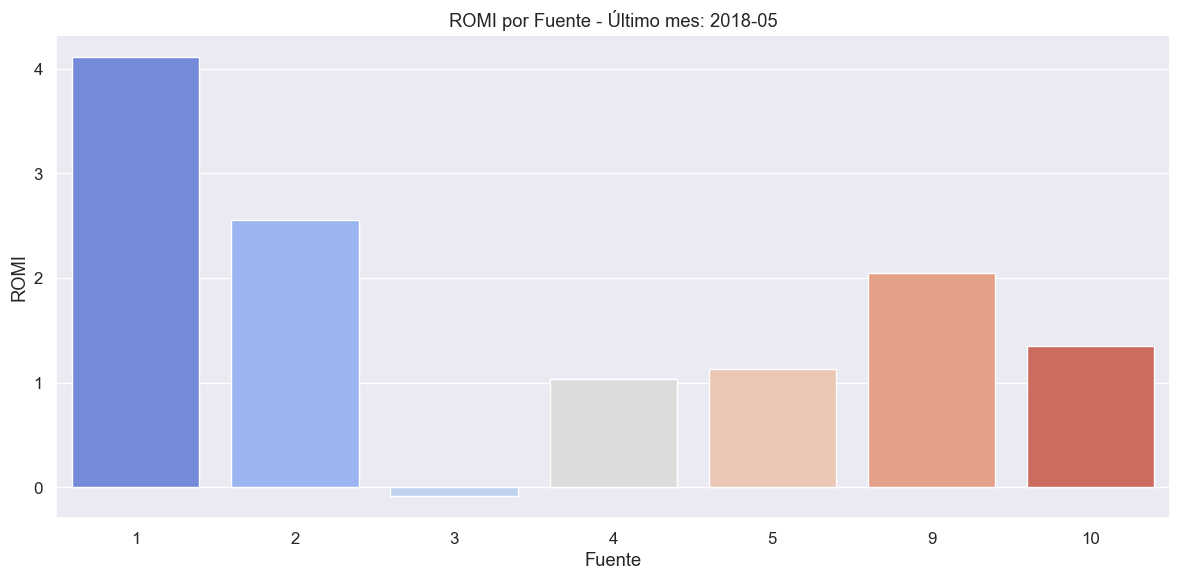

In [187]:
# 3) ROMI (Return On Marketing Investment)
# Ingresos por fuente y mes (suponiendo que orders_with_source tenga 'Source Id')
visits_source = visits[['Uid','Start Ts','Source Id']].drop_duplicates(subset=['Uid','Source Id'])
orders_src = orders.merge(visits_source[['Uid','Source Id']], on='Uid', how='left')
orders_src['order_month'] = orders_src['Buy Ts'].dt.to_period('M')

rev_src = (
    orders_src
    .groupby(['order_month','Source Id'])
    .agg(Revenue=('Revenue','sum'))
    .reset_index()
)

costs_src = costs_pivot.reset_index().melt(id_vars='month', var_name='Source Id', value_name='costs')
costs_src.rename(columns={'month':'order_month'}, inplace=True)

romi_df = (
    rev_src
    .merge(costs_src, on=['order_month','Source Id'], how='inner')
    .assign(ROMI=lambda df: (df['Revenue'] - df['costs']) / df['costs'])
)

# Mostrar tabla ROMI
print(romi_df[['order_month','Source Id','Revenue','costs','ROMI']].sort_values(['order_month','ROMI'], ascending=[True,False]))

# Visualizar ROMI para el último mes
ultimo = romi_df['order_month'].max()
romi_last = romi_df[romi_df['order_month']==ultimo]

plt.figure(figsize=(12,6))
sns.barplot(data=romi_last, x='Source Id', y='ROMI', palette='coolwarm')
plt.title(f'ROMI por Fuente - Último mes: {ultimo}')
plt.xlabel('Fuente')
plt.ylabel('ROMI')
plt.tight_layout()
plt.show()

"Con base en el análisis, determinamos que la fuente número 1 es la más rentable. Además, se reafirma la hipótesis de que la fuente 3 no es rentable, dado que el impacto que genera no compensa su alto costo de adquisición."